In [6]:
#!/bin/bash
!curl -L -o libri-noise-dataset.zip https://www.kaggle.com/api/v1/datasets/download/earth16/libri-speech-noise-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 6178M  100 6178M    0     0   206M      0  0:00:29  0:00:29 --:--:--  223M


In [7]:
!unzip -q libri-noise-dataset.zip

In [8]:
!rm -rf BWAVN.7z epoc-27-results.xltx LibriNoise_Train_Test_NPY ModelArchitecture.txt model.h5.png noisesB.7z NoiseTest.pptx NoiseTest_SNR.pptx results.7z

In [9]:
!7z x train.7z -onoisy > /dev/null

In [10]:
!7z x y_train.7z -odenoised > /dev/null

In [11]:
!7z x test.7z -onoisy > /dev/null
!7z x y_test.7z -odenoised > /dev/null

In [12]:
import librosa
import glob
import matplotlib.pyplot as plt
from IPython.display import Audio, IFrame, display
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm

In [13]:
!ls noisy/train/103-1240-0005.wav

noisy/train/103-1240-0005.wav


In [14]:
!ls denoised/

y_test	y_train


In [15]:
train_noisy_files = sorted(glob.glob('noisy/train/*.wav'))
train_clear_files = sorted(glob.glob('denoised/y_train/*.wav'))
assert len(train_clear_files) == len(train_noisy_files)

In [16]:
train_noisy_files[0], train_clear_files[0]

('noisy/train/103-1240-0005.wav', 'denoised/y_train/103-1240-0005.wav')

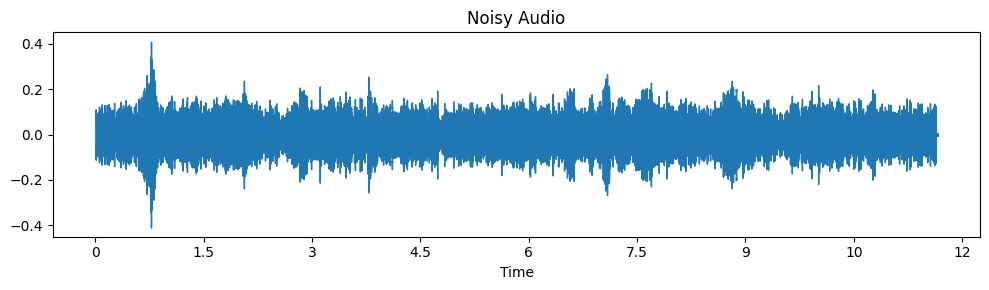

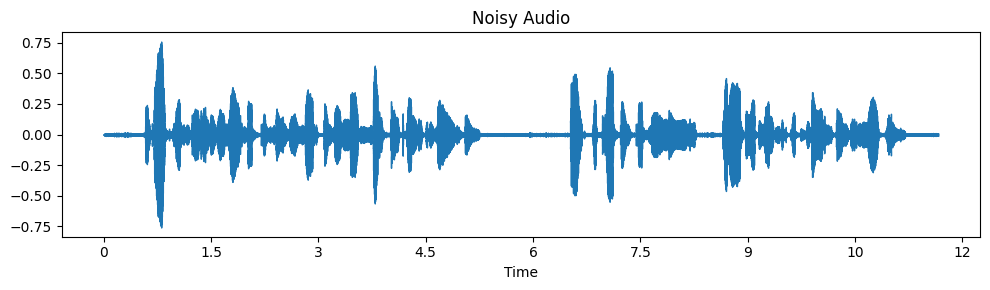

In [17]:
sr = 16000

idx = 1000

x, sr = librosa.load(train_noisy_files[idx], mono=True, sr=sr, offset=0, duration=16)
plt.figure(figsize=(10, 3))
librosa.display.waveshow(x, sr=sr, axis='time')
plt.title("Noisy Audio")
plt.tight_layout()
plt.show()
display(Audio(x,rate=sr))

y, sr = librosa.load(train_clear_files[idx], mono=True, sr=sr, offset=0, duration=16)
plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr, axis='time')
plt.title("Noisy Audio")
plt.tight_layout()
plt.show()
display(Audio(y,rate=sr))

In [37]:
import glob
import librosa
import torch
from torch.utils.data import Dataset
import random
import numpy as np
import random

class MyDataset(Dataset):
    def __init__(self, noisy_folder='noisy/train/', denoised_folder='denoised/y_train/', ind=None, need_crop=False, cnt_seconds=16, need_all=False, single_file_path=None):
        if (single_file_path is not None):
            self.noisy_files = [single_file_path]
            self.clear_files = [single_file_path]
        else:
            self.noisy_files = np.array(sorted(glob.glob(noisy_folder + '*.wav')))
            self.clear_files = np.array(sorted(glob.glob(denoised_folder + '*.wav')))

        assert len(self.noisy_files) == len(self.clear_files)
        for f, s in zip(self.noisy_files, self.clear_files):
            assert f.split('/')[-1] == s.split('/')[-1]

        if ind is not None:
            self.noisy_files = self.noisy_files[ind]
            self.clear_files = self.clear_files[ind]
        self.cnt_seconds = cnt_seconds
        self.sr = 16000
        self.need_crop = need_crop
        self.need_all = need_all
            
    def __len__(self):
        return len(self.noisy_files)

    def __getitem__(self, idx):
        noisy_file = self.noisy_files[idx]
        clear_file = self.clear_files[idx]

        noisy_arr, _ = librosa.load(noisy_file, mono=True, sr=self.sr, offset=0)
        clear_arr, _ = librosa.load(clear_file, mono=True, sr=self.sr, offset=0)

        noisy_arr = torch.tensor(noisy_arr, dtype=torch.float)
        clear_arr = torch.tensor(clear_arr, dtype=torch.float)

        need_size = self.cnt_seconds * self.sr

        if self.need_all:
            noisy_segments = []
            clear_segments = []

            num_segments = max(len(noisy_arr) // need_size, 1)
            for i in range(num_segments):
                start = i * need_size
                noisy_segments.append(noisy_arr[start:start + need_size])
                clear_segments.append(clear_arr[start:start + need_size])

            noisy_segments = [seg if seg.shape[0] == need_size else torch.cat((seg, torch.zeros(need_size - seg.shape[0]))) for seg in noisy_segments]
            clear_segments = [seg if seg.shape[0] == need_size else torch.cat((seg, torch.zeros(need_size - seg.shape[0]))) for seg in clear_segments]
            
            return (torch.stack(noisy_segments).unsqueeze(1), torch.stack(clear_segments).unsqueeze(1))

        if not self.need_crop:
            noisy_arr = torch.cat((noisy_arr[:need_size], torch.zeros(need_size - noisy_arr.shape[0])))
            clear_arr = torch.cat((clear_arr[:need_size], torch.zeros(need_size - clear_arr.shape[0])))
        else:
            l = random.randint(0, max(1, noisy_arr.shape[0] - need_size))
            r = min(l + need_size, noisy_arr.shape[0])
            noisy_arr = noisy_arr[l:r]
            clear_arr = clear_arr[l:r]
            noisy_arr = torch.cat((noisy_arr[:need_size], torch.zeros(need_size - noisy_arr.shape[0])))
            clear_arr = torch.cat((clear_arr[:need_size], torch.zeros(need_size - clear_arr.shape[0])))

        assert noisy_arr.shape == clear_arr.shape

        noisy_arr = noisy_arr.unsqueeze(0)
        clear_arr = clear_arr.unsqueeze(0)

        return (noisy_arr, clear_arr)


In [19]:
n_total = 7000
cnt_valid = 400
all_indices = list(range(n_total))

random.seed(42)
random.shuffle(all_indices)
valid_indices = np.array(all_indices[:cnt_valid])
train_indices = np.array(all_indices[cnt_valid:])

valid_dataset = MyDataset(noisy_folder='noisy/train/', denoised_folder='denoised/y_train/', need_crop=True, cnt_seconds=3, need_all=True, ind=valid_indices)
train_dataset = MyDataset(noisy_folder='noisy/train/', denoised_folder='denoised/y_train/', need_crop=True, cnt_seconds=3, need_all=False, ind=train_indices)
test_dataset = MyDataset(noisy_folder='noisy/test/',  denoised_folder='denoised/y_test/', need_crop=True, cnt_seconds=3, need_all=True)

In [20]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(6600, 400, 105)

In [21]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [22]:
train_dataset[0][0].shape

torch.Size([1, 48000])

In [23]:
class UModel(nn.Module):
    def make_ds_block(self, idx):
        in_channels = (1 if idx == 1 else self.F_c*(idx-1))
        out_channels = self.F_c * idx
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=self.f_d, padding=self.f_d//2),
            nn.BatchNorm1d(out_channels),
            nn.MaxPool1d(kernel_size=2),
            nn.LeakyReLU(0.2),
        )

    def make_us_block(self, idx):
        in_channels = self.F_c * idx * 2
        
        out_channels = self.F_c * idx
        
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=self.f_u, padding=self.f_u//2),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def __init__(self, L, F_c, f_d, f_u, k):
        super().__init__()
        self.L = L
        self.F_c = F_c
        self.f_d = f_d
        self.f_u = f_u
        self.k = k
        
        self.ds_blocks = []
        for i in range(1, L + 1):
            self.ds_blocks.append(self.make_ds_block(i))

        self.back_bone = nn.Conv1d(self.F_c*L, self.F_c*(L+1), kernel_size=self.f_d, padding=self.f_d//2)


        self.us_blocks = [None] * L
        for i in range(1, L + 1, 1):
             self.us_blocks[i - 1] = self.make_us_block(i)

        self.conv1d_blocks = [None] * L
        for i in range(1, L + 1, 1):
            in_channels = self.F_c*(i+1)
            out_channels = self.F_c*i
            self.conv1d_blocks[i - 1] = nn.Conv1d(in_channels, out_channels, kernel_size=1)
            
        self.ds_blocks = nn.ModuleList(self.ds_blocks)
        self.us_blocks = nn.ModuleList(self.us_blocks)
        self.conv1d_blocks = nn.ModuleList(self.conv1d_blocks)

        self.Final_block = nn.Sequential(
            nn.Conv1d(self.F_c + 1, self.k, kernel_size=1, padding=0),
            nn.BatchNorm1d(self.k),
            nn.Tanh(),
        )

    def forward(self, X):
        
        ds_tensors = []
        ds_tensors.append(X)
        for i in range(1, self.L + 1):
            X = self.ds_blocks[i - 1](X)
            ds_tensors.append(X)

        X = self.back_bone(X)
        for i in range(self.L, 0, -1):
            if (i < self.L):
                cur_X = F.interpolate(X, scale_factor=2, mode='linear') # B x self.F_c*(idx+1) x n_f
            else:
                cur_X = X
            cur_X = self.conv1d_blocks[i - 1](cur_X)
            skip = ds_tensors[i]

            len_cur = cur_X.size(-1)
            len_skip = skip.size(-1)
            if len_cur < len_skip:
                cur_X = F.pad(cur_X, (0, len_skip - len_cur))
            elif len_cur > len_skip:
                cur_X = cur_X[..., :len_skip]
        
                
            new_X = torch.concat((cur_X, skip), dim=1)
            
            X = self.us_blocks[i - 1](new_X)

        X = F.interpolate(X, scale_factor=2, mode='linear')
        
        new_X = torch.concat((X, ds_tensors[0]), dim=1)
        X = self.Final_block(new_X)
        return X

# model = UModel(L=10, F_c=24, f_d=15, f_u=5, k=10)

In [24]:
!pip install pesq
from torchmetrics.audio import ScaleInvariantSignalDistortionRatio
from pesq import pesq

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp311-cp311-linux_x86_64.whl size=275941 sha256=fd5523ec42b51227229781bebf81703e0f47b1d4397722c14a8696d813f617b3
  Stored in directory: /root/.cache/pip/wheels/ae/f1/23/2698d0bf31eec2b2aa50623b5d93b6206c49c7155d0e31345d
Successfully built pesq


In [25]:
def calculate_batch_SI_SDR(preds_batch, y_batch, SI_SDR_metric):
    sum_metric = 0
    for cur_pred, cur_y in zip(preds_batch, y_batch):
        try:
            cur = SI_SDR_metric(cur_pred, cur_y)
            sum_metric += cur
        except:
            continue
    return sum_metric / len(preds_batch)

def calculate_batch_PESQ(preds_batch, y_batch, fs=16000, mode='wb'):
    total, count = 0.0, 0
    for cur_pred, cur_y in zip(preds_batch, y_batch):
        ref = cur_y.squeeze(0).detach().cpu().numpy()
        deg = cur_pred.squeeze(0).detach().cpu().numpy()

        try:
            score = pesq(fs, ref=ref, deg=deg, mode=mode)
            total += score
            count += 1
        except:
            continue

    return total / count if count > 0 else 0.0

In [26]:
from torchmetrics.audio import ScaleInvariantSignalDistortionRatio

def train(model, criterion, train_dataloader, valid_dataset, optimizer, epochs, device, metrics):
    best_sdr = -1e6
    best_loss = 1e6

    SI_SDR_metric = ScaleInvariantSignalDistortionRatio(
        zero_mean=True,
    ).to(device)
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0        

        cnt_steps_train = len(train_dataloader)
        for batch_x, batch_y in tqdm(train_dataloader):

            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            preds = model(batch_x)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            with torch.no_grad():
                train_loss += loss.item()


        train_loss /= cnt_steps_train
        print(f'Epoch {epoch}/{epochs} | Train Loss: {train_loss:.6f}')

        metrics['train_loss'].append(train_loss)
        
        model.eval()
        valid_loss = 0
        valid_sdr = 0
        # valid_pesq = 0
        with torch.no_grad():
            for batch_x, batch_y in tqdm(valid_dataset):
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                # print(batch_x.shape, batch_y.shape)
                
                preds = model(batch_x)
                loss = criterion(preds, batch_y)
                valid_loss += loss.item()
                
                valid_sdr += SI_SDR_metric(preds, batch_y)
                
                # valid_pesq += calculate_batch_PESQ(preds, batch_y)
                
        valid_loss /= len(valid_dataset)
        valid_sdr /= len(valid_dataset)
        # valid_pesq /= len(valid_dataset)
        

        print(f'Epoch {epoch}/{epochs} | Valid Loss: {valid_loss:.6f} | Valid SI-SDR: {valid_sdr:.4f}')
        
        metrics['valid_loss'].append(valid_loss)
        metrics['valid_si_sdr'].append(valid_sdr)
        # metrics['valid_pesq'].append(valid_pesq)

        if valid_sdr > best_sdr:
            best_sdr = valid_sdr
            sdr_model = model
        if valid_loss < best_loss:
            best_loss = valid_loss
            loss_model = model
            
    return sdr_model, loss_model

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = UModel(L=10, F_c=24, f_d=15, f_u=5, k=1).to(device)
model = UModel(L=12, F_c=24, f_d=15, f_u=5, k=1).to(device)

model = nn.DataParallel(model, device_ids=['cuda:0', 'cuda:1'])

metrics = {
    'train_loss': [],
    'train_si_sdr': [],
    'train_pesq': [],
    'valid_loss': [],
    'valid_si_sdr': [],
    'valid_pesq': []
}


In [31]:
def si_sdr_loss(pred, ref, eps=1e-8):
    # pred/ref shape: [B, 1, T]
    ref_energy = torch.sum(ref**2, dim=-1, keepdim=True) + eps
    proj = torch.sum(pred * ref, dim=-1, keepdim=True) * ref / ref_energy
    ####.
    noise = pred - proj
    # return -10 * torch.log10(torch.sum(proj**2, dim=-1) / (torch.sum(noise**2, dim=-1) + eps)).mean()
    
    num = torch.sum(proj**2, dim=-1)
    den = torch.sum(noise**2, dim=-1)
    ratio = num / (den + eps)
    ratio = torch.clamp(ratio, min=eps)
    sisd = 10 * torch.log10(ratio)
    return -sisd.mean()


criterion = si_sdr_loss

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
best_sdr, best_mse = train(model, criterion, train_dataloader, valid_dataset, optimizer, 15, device, metrics)

100%|██████████| 104/104 [01:24<00:00,  1.23it/s]


Epoch 1/15 | Train Loss: -0.432440


100%|██████████| 400/400 [00:23<00:00, 17.05it/s]


Epoch 1/15 | Valid Loss: -1.657464 | Valid SI-SDR: 1.9658


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 2/15 | Train Loss: -2.875014


100%|██████████| 400/400 [00:23<00:00, 16.85it/s]


Epoch 2/15 | Valid Loss: -3.388306 | Valid SI-SDR: 3.6304


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 3/15 | Train Loss: -3.935941


100%|██████████| 400/400 [00:23<00:00, 17.02it/s]


Epoch 3/15 | Valid Loss: -4.624877 | Valid SI-SDR: 4.7060


100%|██████████| 104/104 [01:27<00:00,  1.19it/s]


Epoch 4/15 | Train Loss: -4.797871


100%|██████████| 400/400 [00:23<00:00, 17.10it/s]


Epoch 4/15 | Valid Loss: -4.092888 | Valid SI-SDR: 4.2406


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 5/15 | Train Loss: -5.167309


100%|██████████| 400/400 [00:23<00:00, 17.17it/s]


Epoch 5/15 | Valid Loss: 0.030881 | Valid SI-SDR: 0.3717


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 6/15 | Train Loss: -4.661495


100%|██████████| 400/400 [00:23<00:00, 17.39it/s]


Epoch 6/15 | Valid Loss: -5.115862 | Valid SI-SDR: 5.2300


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 7/15 | Train Loss: -5.559308


100%|██████████| 400/400 [00:23<00:00, 17.26it/s]


Epoch 7/15 | Valid Loss: -5.997947 | Valid SI-SDR: 6.3017


100%|██████████| 104/104 [01:27<00:00,  1.19it/s]


Epoch 8/15 | Train Loss: -5.442709


100%|██████████| 400/400 [00:22<00:00, 17.69it/s]


Epoch 8/15 | Valid Loss: 2.274144 | Valid SI-SDR: -1.3921


100%|██████████| 104/104 [01:27<00:00,  1.19it/s]


Epoch 9/15 | Train Loss: -5.445772


100%|██████████| 400/400 [00:22<00:00, 17.51it/s]


Epoch 9/15 | Valid Loss: -5.278949 | Valid SI-SDR: 5.3450


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 10/15 | Train Loss: -5.744780


100%|██████████| 400/400 [00:22<00:00, 17.73it/s]


Epoch 10/15 | Valid Loss: -4.192316 | Valid SI-SDR: 4.3828


100%|██████████| 104/104 [01:27<00:00,  1.19it/s]


Epoch 11/15 | Train Loss: -5.316842


100%|██████████| 400/400 [00:23<00:00, 17.32it/s]


Epoch 11/15 | Valid Loss: 3.228948 | Valid SI-SDR: -2.8348


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 12/15 | Train Loss: -4.452422


100%|██████████| 400/400 [00:22<00:00, 17.68it/s]


Epoch 12/15 | Valid Loss: -5.013259 | Valid SI-SDR: 5.0690


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 13/15 | Train Loss: -5.713576


100%|██████████| 400/400 [00:23<00:00, 17.22it/s]


Epoch 13/15 | Valid Loss: -6.251743 | Valid SI-SDR: 6.3176


100%|██████████| 104/104 [01:27<00:00,  1.19it/s]


Epoch 14/15 | Train Loss: -6.104987


100%|██████████| 400/400 [00:22<00:00, 17.88it/s]


Epoch 14/15 | Valid Loss: -6.767657 | Valid SI-SDR: 6.8807


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 15/15 | Train Loss: -6.306565


100%|██████████| 400/400 [00:23<00:00, 17.28it/s]

Epoch 15/15 | Valid Loss: -6.411330 | Valid SI-SDR: 6.4584


In [32]:
model = best_sdr

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
best_sdr, best_mse = train(model, criterion, train_dataloader, valid_dataset, optimizer, 25, device, metrics)

100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 1/25 | Train Loss: -6.436338


100%|██████████| 400/400 [00:23<00:00, 17.36it/s]


Epoch 1/25 | Valid Loss: -5.943020 | Valid SI-SDR: 6.1097


100%|██████████| 104/104 [01:27<00:00,  1.19it/s]


Epoch 2/25 | Train Loss: -6.034588


100%|██████████| 400/400 [00:23<00:00, 17.25it/s]


Epoch 2/25 | Valid Loss: -6.950242 | Valid SI-SDR: 6.9994


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 3/25 | Train Loss: -6.526593


100%|██████████| 400/400 [00:23<00:00, 17.33it/s]


Epoch 3/25 | Valid Loss: -7.134938 | Valid SI-SDR: 7.2200


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 4/25 | Train Loss: -6.769899


100%|██████████| 400/400 [00:24<00:00, 16.62it/s]


Epoch 4/25 | Valid Loss: -7.188086 | Valid SI-SDR: 7.2625


100%|██████████| 104/104 [01:27<00:00,  1.19it/s]


Epoch 5/25 | Train Loss: -6.718278


100%|██████████| 400/400 [00:22<00:00, 17.55it/s]


Epoch 5/25 | Valid Loss: -7.161039 | Valid SI-SDR: 7.1692


100%|██████████| 104/104 [01:27<00:00,  1.19it/s]


Epoch 6/25 | Train Loss: -7.016011


100%|██████████| 400/400 [00:23<00:00, 17.29it/s]


Epoch 6/25 | Valid Loss: -7.493534 | Valid SI-SDR: 7.5152


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 7/25 | Train Loss: -7.096999


100%|██████████| 400/400 [00:23<00:00, 17.17it/s]


Epoch 7/25 | Valid Loss: -7.491736 | Valid SI-SDR: 7.5447


100%|██████████| 104/104 [01:27<00:00,  1.19it/s]


Epoch 8/25 | Train Loss: -7.174727


100%|██████████| 400/400 [00:23<00:00, 17.21it/s]


Epoch 8/25 | Valid Loss: -7.742898 | Valid SI-SDR: 7.7701


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 9/25 | Train Loss: -7.271645


100%|██████████| 400/400 [00:23<00:00, 16.96it/s]


Epoch 9/25 | Valid Loss: -7.632742 | Valid SI-SDR: 7.6835


100%|██████████| 104/104 [01:27<00:00,  1.19it/s]


Epoch 10/25 | Train Loss: -7.323310


100%|██████████| 400/400 [00:22<00:00, 17.44it/s]


Epoch 10/25 | Valid Loss: -7.467782 | Valid SI-SDR: 7.4942


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 11/25 | Train Loss: -7.145616


100%|██████████| 400/400 [00:23<00:00, 17.18it/s]


Epoch 11/25 | Valid Loss: -7.303385 | Valid SI-SDR: 7.2992


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 12/25 | Train Loss: -7.261480


100%|██████████| 400/400 [00:22<00:00, 17.59it/s]


Epoch 12/25 | Valid Loss: -7.841281 | Valid SI-SDR: 7.8504


100%|██████████| 104/104 [01:27<00:00,  1.19it/s]


Epoch 13/25 | Train Loss: -7.466485


100%|██████████| 400/400 [00:23<00:00, 17.06it/s]


Epoch 13/25 | Valid Loss: -7.945550 | Valid SI-SDR: 7.9574


100%|██████████| 104/104 [01:27<00:00,  1.19it/s]


Epoch 14/25 | Train Loss: -7.549767


100%|██████████| 400/400 [00:22<00:00, 17.53it/s]


Epoch 14/25 | Valid Loss: -7.972717 | Valid SI-SDR: 7.9845


100%|██████████| 104/104 [01:27<00:00,  1.19it/s]


Epoch 15/25 | Train Loss: -7.572928


100%|██████████| 400/400 [00:22<00:00, 17.48it/s]


Epoch 15/25 | Valid Loss: -8.109217 | Valid SI-SDR: 8.1519


100%|██████████| 104/104 [01:27<00:00,  1.19it/s]


Epoch 16/25 | Train Loss: -7.655019


100%|██████████| 400/400 [00:22<00:00, 17.86it/s]


Epoch 16/25 | Valid Loss: -8.152200 | Valid SI-SDR: 8.1359


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 17/25 | Train Loss: -7.768125


100%|██████████| 400/400 [00:23<00:00, 17.31it/s]


Epoch 17/25 | Valid Loss: -8.003889 | Valid SI-SDR: 8.0435


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 18/25 | Train Loss: -7.817781


100%|██████████| 400/400 [00:22<00:00, 17.49it/s]


Epoch 18/25 | Valid Loss: -8.268938 | Valid SI-SDR: 8.3019


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 19/25 | Train Loss: -7.859528


100%|██████████| 400/400 [00:22<00:00, 17.68it/s]


Epoch 19/25 | Valid Loss: -8.260427 | Valid SI-SDR: 8.2396


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 20/25 | Train Loss: -7.878724


100%|██████████| 400/400 [00:22<00:00, 17.51it/s]


Epoch 20/25 | Valid Loss: -8.238773 | Valid SI-SDR: 8.2234


100%|██████████| 104/104 [01:27<00:00,  1.19it/s]


Epoch 21/25 | Train Loss: -7.953652


100%|██████████| 400/400 [00:23<00:00, 17.26it/s]


Epoch 21/25 | Valid Loss: -8.346934 | Valid SI-SDR: 8.3659


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 22/25 | Train Loss: -8.027816


100%|██████████| 400/400 [00:23<00:00, 17.09it/s]


Epoch 22/25 | Valid Loss: -8.503104 | Valid SI-SDR: 8.4953


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 23/25 | Train Loss: -8.094006


100%|██████████| 400/400 [00:22<00:00, 17.44it/s]


Epoch 23/25 | Valid Loss: -8.472814 | Valid SI-SDR: 8.4850


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 24/25 | Train Loss: -8.144148


100%|██████████| 400/400 [00:23<00:00, 17.04it/s]


Epoch 24/25 | Valid Loss: -8.487526 | Valid SI-SDR: 8.4863


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 25/25 | Train Loss: -8.133563


100%|██████████| 400/400 [00:23<00:00, 17.29it/s]

Epoch 25/25 | Valid Loss: -8.418999 | Valid SI-SDR: 8.4051


In [34]:
model = best_sdr

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
best_sdr, best_mse = train(model, criterion, train_dataloader, valid_dataset, optimizer, 20, device, metrics)

100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 1/20 | Train Loss: -8.338870


100%|██████████| 400/400 [00:23<00:00, 17.04it/s]


Epoch 1/20 | Valid Loss: -8.810790 | Valid SI-SDR: 8.8194


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 2/20 | Train Loss: -8.407202


100%|██████████| 400/400 [00:22<00:00, 17.45it/s]


Epoch 2/20 | Valid Loss: -8.830551 | Valid SI-SDR: 8.8182


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 3/20 | Train Loss: -8.336588


100%|██████████| 400/400 [00:23<00:00, 17.34it/s]


Epoch 3/20 | Valid Loss: -8.284021 | Valid SI-SDR: 8.4488


100%|██████████| 104/104 [01:26<00:00,  1.21it/s]


Epoch 4/20 | Train Loss: -8.456601


100%|██████████| 400/400 [00:22<00:00, 17.64it/s]


Epoch 4/20 | Valid Loss: -8.968455 | Valid SI-SDR: 8.9571


100%|██████████| 104/104 [01:25<00:00,  1.21it/s]


Epoch 5/20 | Train Loss: -8.511513


100%|██████████| 400/400 [00:23<00:00, 17.31it/s]


Epoch 5/20 | Valid Loss: -8.848032 | Valid SI-SDR: 8.8402


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 6/20 | Train Loss: -8.567131


100%|██████████| 400/400 [00:22<00:00, 17.84it/s]


Epoch 6/20 | Valid Loss: -8.947464 | Valid SI-SDR: 8.9503


100%|██████████| 104/104 [01:27<00:00,  1.19it/s]


Epoch 7/20 | Train Loss: -8.542594


100%|██████████| 400/400 [00:22<00:00, 17.40it/s]


Epoch 7/20 | Valid Loss: -9.043582 | Valid SI-SDR: 9.0385


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 8/20 | Train Loss: -8.613398


100%|██████████| 400/400 [00:22<00:00, 17.88it/s]


Epoch 8/20 | Valid Loss: -9.026766 | Valid SI-SDR: 9.0264


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 9/20 | Train Loss: -8.597005


100%|██████████| 400/400 [00:22<00:00, 17.51it/s]


Epoch 9/20 | Valid Loss: -9.058900 | Valid SI-SDR: 9.0476


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 10/20 | Train Loss: -8.687929


100%|██████████| 400/400 [00:22<00:00, 17.50it/s]


Epoch 10/20 | Valid Loss: -9.080879 | Valid SI-SDR: 9.0903


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 11/20 | Train Loss: -7.775801


100%|██████████| 400/400 [00:22<00:00, 17.57it/s]


Epoch 11/20 | Valid Loss: -8.571871 | Valid SI-SDR: 8.6013


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 12/20 | Train Loss: -8.386630


100%|██████████| 400/400 [00:23<00:00, 17.08it/s]


Epoch 12/20 | Valid Loss: -8.725279 | Valid SI-SDR: 8.7703


100%|██████████| 104/104 [01:27<00:00,  1.19it/s]


Epoch 13/20 | Train Loss: -8.588692


100%|██████████| 400/400 [00:22<00:00, 17.52it/s]


Epoch 13/20 | Valid Loss: -9.084012 | Valid SI-SDR: 9.0597


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 14/20 | Train Loss: -8.667306


100%|██████████| 400/400 [00:23<00:00, 17.17it/s]


Epoch 14/20 | Valid Loss: -9.018325 | Valid SI-SDR: 9.0215


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 15/20 | Train Loss: -8.578538


100%|██████████| 400/400 [00:22<00:00, 17.50it/s]


Epoch 15/20 | Valid Loss: -9.166559 | Valid SI-SDR: 9.1567


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 16/20 | Train Loss: -8.732577


100%|██████████| 400/400 [00:23<00:00, 17.09it/s]


Epoch 16/20 | Valid Loss: -8.904092 | Valid SI-SDR: 8.9025


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 17/20 | Train Loss: -8.767899


100%|██████████| 400/400 [00:22<00:00, 17.59it/s]


Epoch 17/20 | Valid Loss: -9.254553 | Valid SI-SDR: 9.2374


100%|██████████| 104/104 [01:26<00:00,  1.21it/s]


Epoch 18/20 | Train Loss: -8.821623


100%|██████████| 400/400 [00:23<00:00, 17.08it/s]


Epoch 18/20 | Valid Loss: -9.244476 | Valid SI-SDR: 9.2215


100%|██████████| 104/104 [01:26<00:00,  1.20it/s]


Epoch 19/20 | Train Loss: -8.877571


100%|██████████| 400/400 [00:22<00:00, 17.86it/s]


Epoch 19/20 | Valid Loss: -9.173271 | Valid SI-SDR: 9.1622


100%|██████████| 104/104 [01:27<00:00,  1.19it/s]


Epoch 20/20 | Train Loss: -8.847559


100%|██████████| 400/400 [00:23<00:00, 17.26it/s]

Epoch 20/20 | Valid Loss: -9.277316 | Valid SI-SDR: 9.2617


In [36]:
model = best_sdr

In [37]:
torch.save(model.module.state_dict(), 'model.pt')

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    plt.figure(figsize=(12, 10))

    
    plt.subplot(2, 1, 1)
    plt.plot(epochs, metrics['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, metrics['valid_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()


    
    plt.subplot(2, 1, 2)
    plt.plot(epochs, metrics['valid_si_sdr'], label='Validation SI-SDR', marker='o')
    plt.title('Validation SDR')
    plt.xlabel('Epochs')
    plt.ylabel('SI-SDR')
    plt.legend()
    plt.grid()



    plt.tight_layout()
    plt.show()


In [39]:
# metrics['train_si_sdr'] = [cur.item() for cur in metrics['train_si_sdr']]
metrics['valid_si_sdr'] = [cur.item() for cur in metrics['valid_si_sdr']]

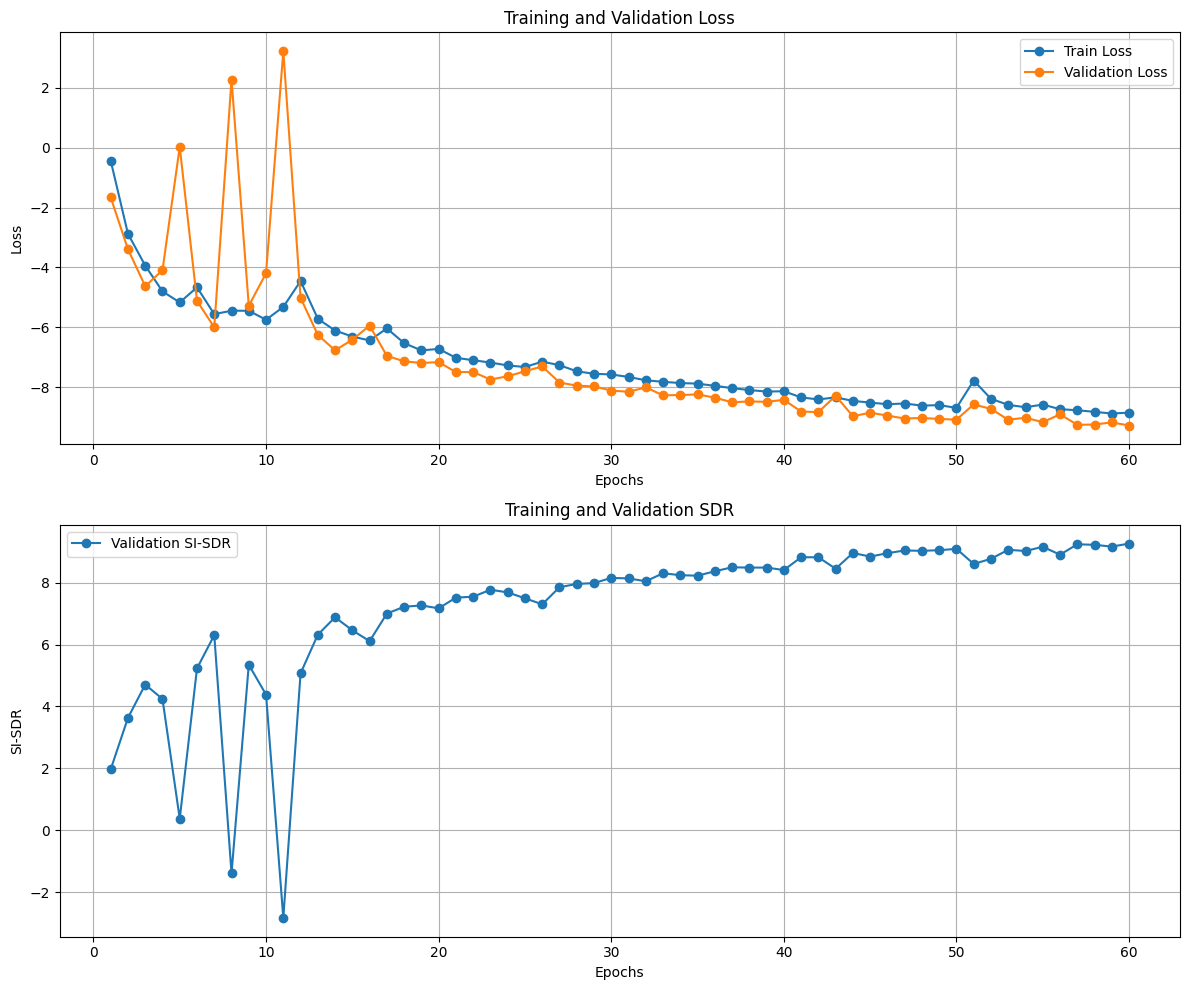

In [40]:
plot_metrics(metrics)

In [33]:
def evaluate_test(model, test_dataset, device, criterion):
    model.eval()
    SI_SDR_metric = ScaleInvariantSignalDistortionRatio(
        zero_mean=True,  
    ).to(device)
    loss = 0
    si_sdr = 0
    pesq = 0
    with torch.no_grad():
        for batch_x, batch_y in tqdm(test_dataset):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            preds = model(batch_x)

            loss += criterion(preds, batch_y)
            si_sdr += SI_SDR_metric(preds, batch_y)
            pesq += calculate_batch_PESQ(preds, batch_y)
    loss /= len(test_dataset)
    si_sdr /= len(test_dataset)
    pesq /= len(test_dataset)
    print(f'Test Loss: {loss}, Test SI-SDR: {si_sdr}, Test PESQ: {pesq}')

In [34]:
evaluate_test(model, test_dataset, device, criterion)

100%|██████████| 105/105 [01:05<00:00,  1.60it/s]

Test Loss: -8.527146339416504, Test SI-SDR: 8.529809951782227, Test PESQ: 1.3428624216526268


In [ ]:
def denoise_file(path, model, device, cnt_seconds=3):
    sr = 16000
    noise_arr,_ = librosa.load(path, mono=True, sr=sr, offset=0, duration=16)
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(noise_arr, sr=sr, axis='time')
    plt.title("Noisy Audio")
    plt.tight_layout()
    plt.show()
    display(Audio(noise_arr,rate=sr))

    with torch.no_grad():
        cur_dataset = MyDataset(need_crop=True, cnt_seconds=3, need_all=True, single_file_path=path)
        clear_audio = model(cur_dataset[0][0]).detach().cpu().numpy()
        clear_audio = clear_audio.reshape(-1)
        
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(clear_audio, sr=sr, axis='time')
    plt.title("Noisy Audio")
    plt.tight_layout()
    plt.show()
    display(Audio(clear_audio,rate=sr))

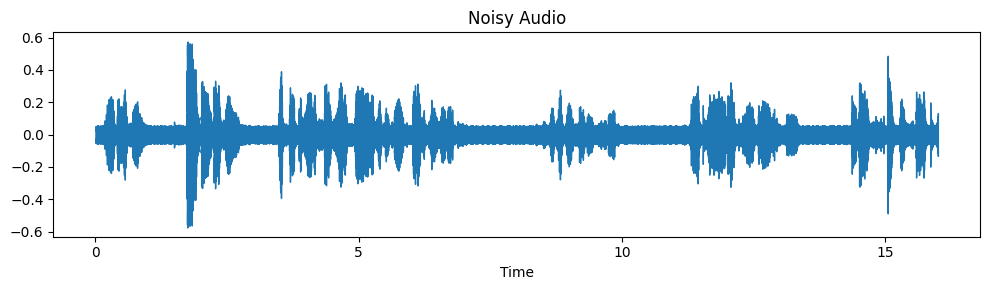

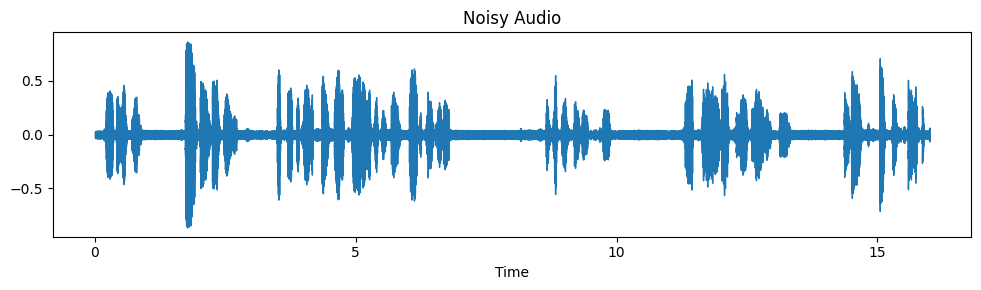

In [39]:
denoise_file('noisy/test/1034-121119-0049.wav', model, device)

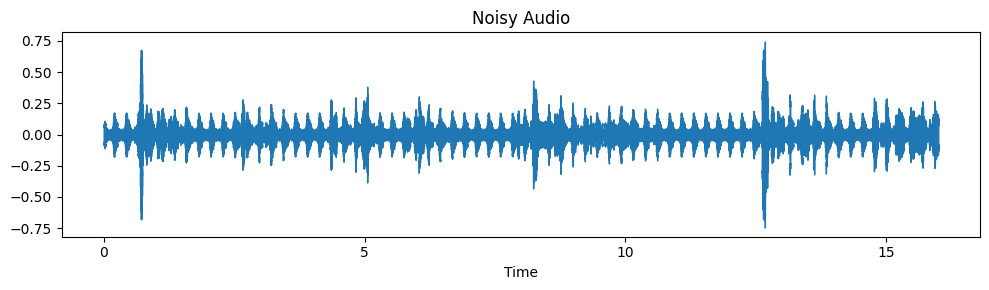

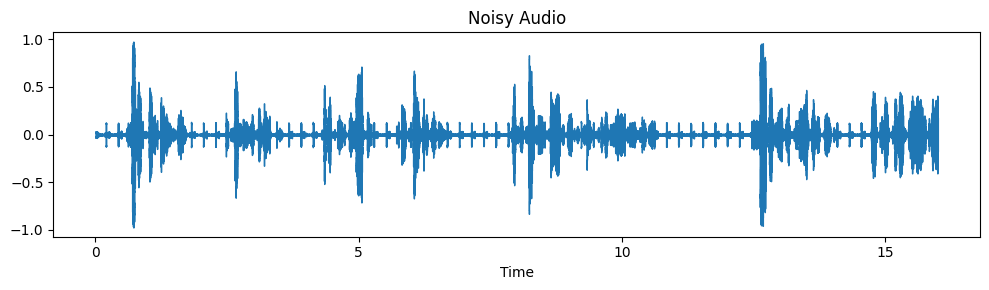

In [40]:
denoise_file('noisy/test/1040-133433-0080.wav', model, device)

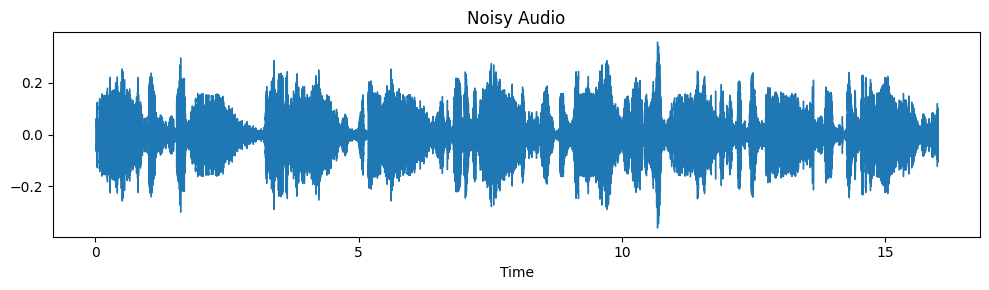

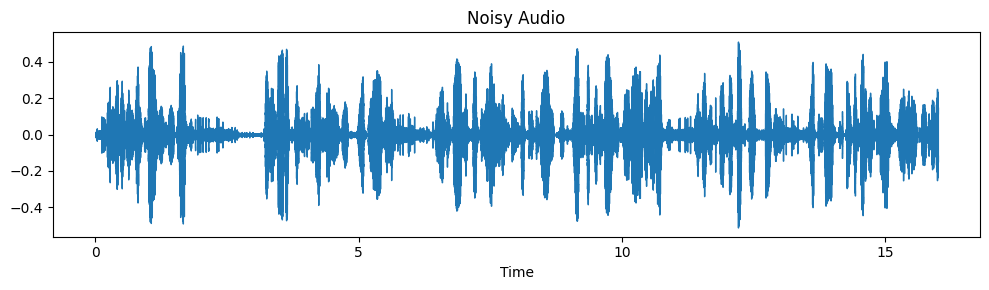

In [41]:
denoise_file('noisy/test/1081-125237-0053.wav', model, device)

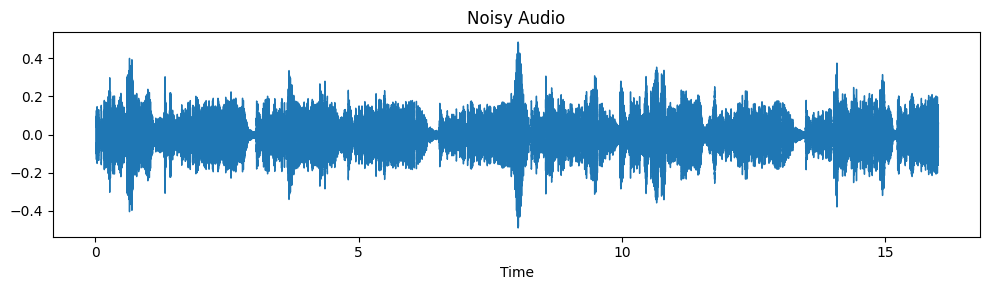

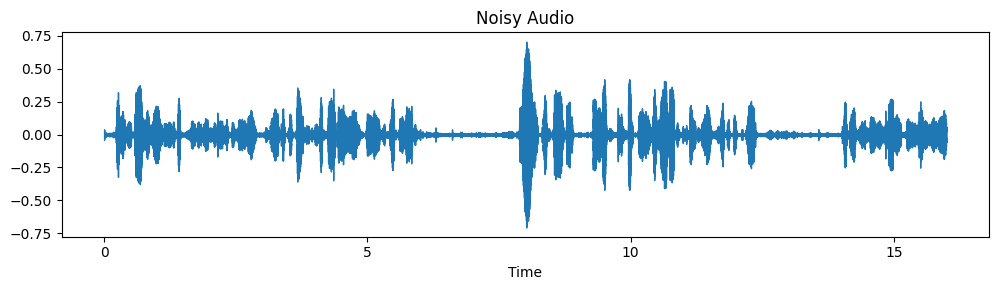

In [42]:
denoise_file('noisy/test/226-131532-0003.wav', model, device)

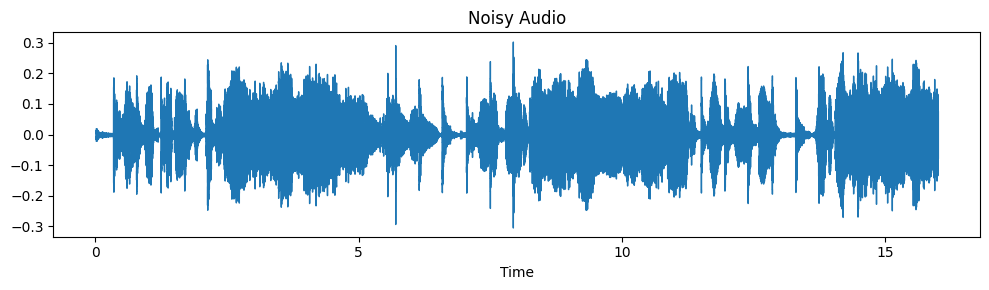

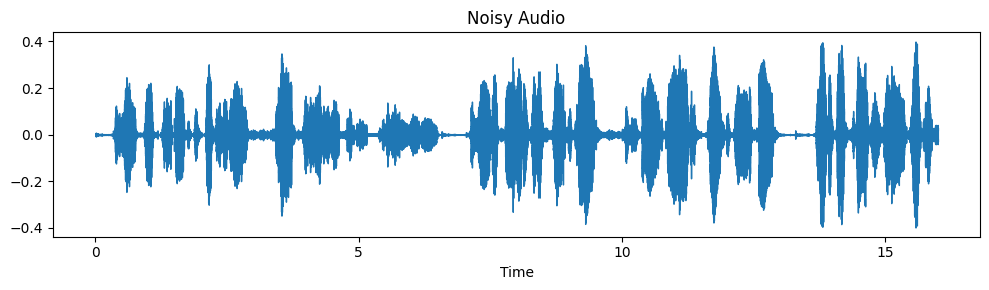

In [43]:
denoise_file('noisy/test/6848-252323-0032.wav', model, device)

In [41]:
!rm -rf denoised libri-noise-dataset.zip noisy samples.7z test.7z train.7z y_test.7z y_train.7z